In [46]:
import pandas as pd
s = pd.Series([[1,2,3],[2,3,4]])
df = s.explode().reset_index()
df.columns=["tick", "price"]
df


,tick,price
0,0,1
1,0,2
2,0,3
3,1,2
4,1,3
5,1,4


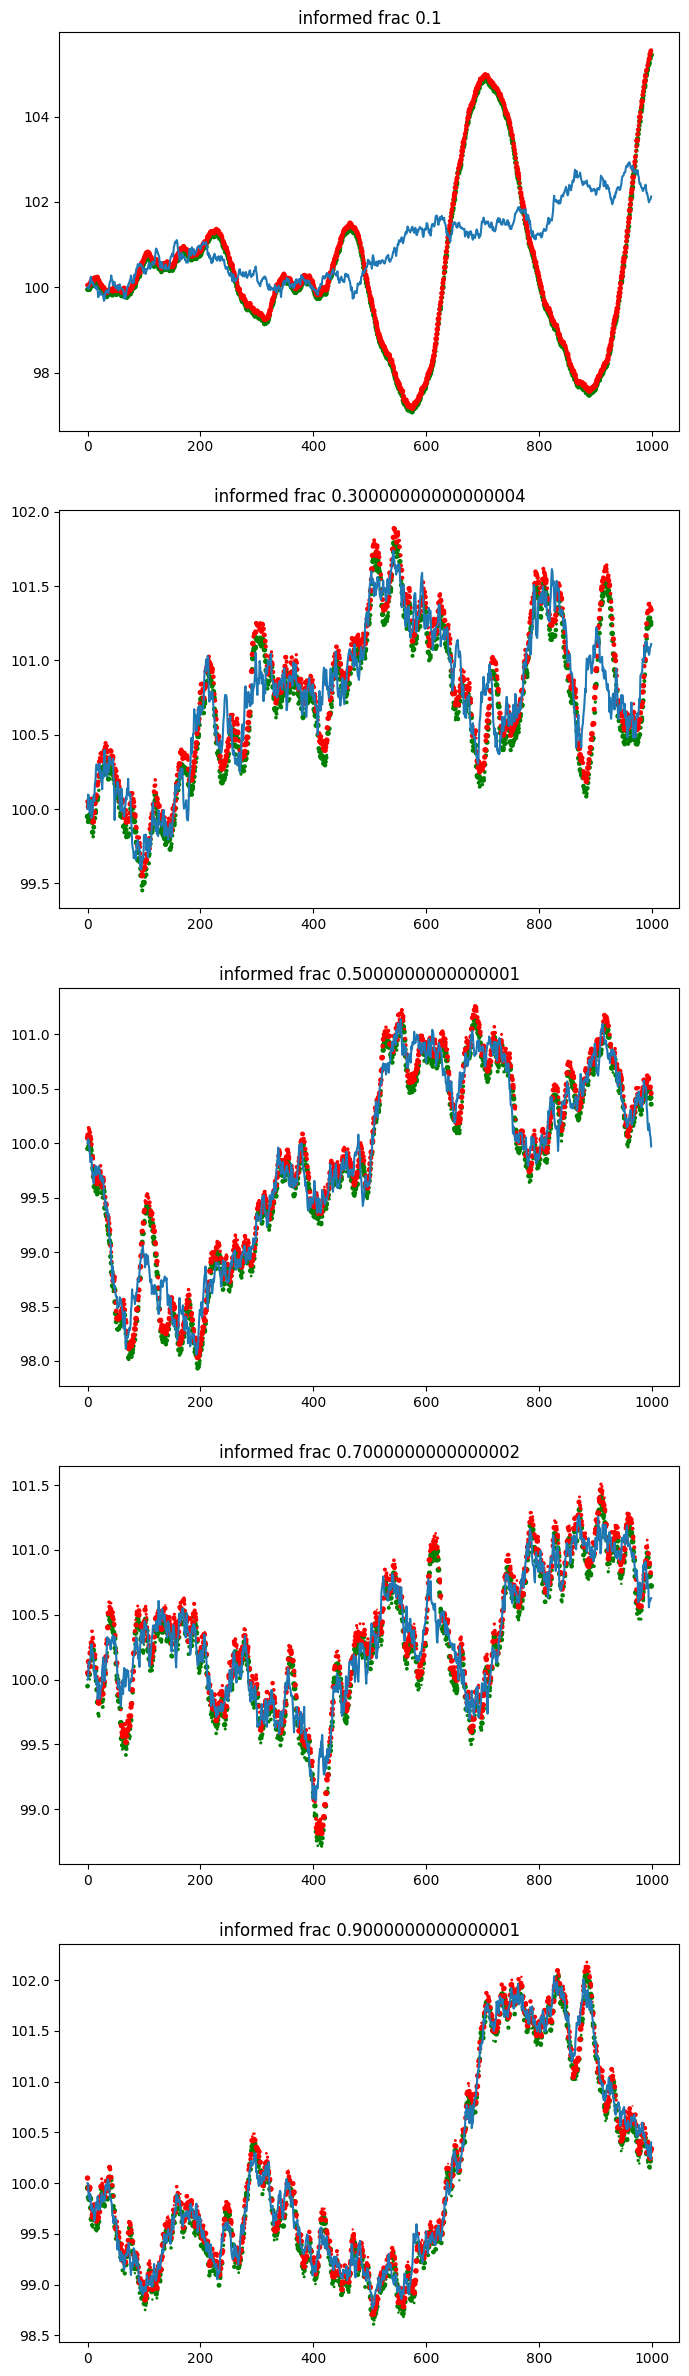

In [28]:
from lob_sim import (
    OrderBook,
    MarketMaker,
    SkewMarketMakingStrategy,
    InformedTraders,
    Asset,
)
from itertools import chain
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(seed=2)
def simulate_quick(info_frac, sigma, skew_coefficient):
    a = Asset(sigma=sigma)
    ob = OrderBook(min_lifetime=0)
    strat = SkewMarketMakingStrategy(0.1, 100, float('inf'),skew_coefficient)
    mm = MarketMaker(strat, initial_capital=1_000_000)
    it = InformedTraders(info_frac, 25, 10)
    timesteps = 1000
    trades_notifications = []

    asset_value = []
    bid_price_volume_history = []
    ask_price_volume_history = []
    for _ in range(timesteps):
        bid_price_volume = {}
        ask_price_volume = {}
        ob.advance()
        quotes, cancellations = mm.update(ob, trades_notifications)
        market_orders = it.generate_orders(a.value, ob.mid_price, rng=rng)
        ob.process_cancellations(cancellations)
        notifs = ob.process_orders(chain(quotes, market_orders))
        trades_notifications = notifs[1] if notifs else []
        for notif in trades_notifications:
            if notif.is_bid:
                for p, v in notif.price_volume.items():
                    bid_price_volume[p] = bid_price_volume.get(p, 0) + v
            else: 
                for p, v in notif.price_volume.items():
                    ask_price_volume[p] = ask_price_volume.get(p, 0) + v
        bid_price_volume_history.append(bid_price_volume)
        ask_price_volume_history.append(ask_price_volume)
        price_volume = {}
        asset_value.append(a.value)
        a.evolve_value(rng=rng)
    return (bid_price_volume_history, ask_price_volume_history, asset_value)

def moving_avg(array, window_size):
    window_size = window_size if len(array) > window_size else len(array)
    cumsum = np.cumsum(np.insert(array, 0, 0))
    return (cumsum[window_size:] - cumsum[:-window_size]) / window_size 

def markout(mm_history, tau, window_size=50):
    net_volume = np.array(mm_history["buy volume"]) - np.array(mm_history["sell volume"])
    mid_price = np.array(mm_history["mid price"])
    
    # Future price change: mid[t+tau] - mid[t]
    delta_mp = mid_price[tau:] - mid_price[:-tau]
    
    # Markout only defined for times where we have t+tau data
    markout = -(net_volume[:-tau] * delta_mp)
    
    markout = moving_avg(markout, window_size)
    
    return markout

def inventory_risk(mm_history, window_size=50):
    inventory = np.array(mm_history["inventory"])
    mp = np.array(mm_history["mid price"])
    delta_mp = mp[1:] - mp[:-1]
    delta_exposure = inventory[:-1] * delta_mp
    E_x = moving_avg(delta_exposure, window_size)
    E_x2 = moving_avg(delta_exposure ** 2, window_size)
    return np.sqrt(E_x2 - E_x ** 2)

# mo = markout(mm.history, 10, 50)
# ir = inventory_risk(mm.history, 50)
# pnl = moving_avg(mm.history["mark-to-market"], 50)

# fi, a = plt.subplots(nrows=1, figsize=(8,8))
# a[0].plot(mo, label="markout")
# a[1].plot(ir, label="inventory risk")
# a[2].plot(pnl, label="pnl")
# plt.legend()

# tau = np.arange(1,50,1)
# def markout_curves(mm_history, tau_list, t):
#     curve = []
#     for tau in tau_list:
#         curve.append(markout(mm_history, tau)[t])
#     return curve



def show_trades(args):
    bpvh = args[0]
    apvh = args[1]
    asset_path = args[2]
    x_bid = []
    x_ask = []
    y_bid = []
    y_ask = []
    s_ask = []
    s_bid =[]
    for t, pv in enumerate(bpvh):
        x_bid.extend([t]*len(pv))
        y_bid.extend(list(pv.keys()))
        s_bid.extend(list(pv.values()))
    for t, pv in enumerate(apvh):
        x_ask.extend([t]*len(pv))
        y_ask.extend(list(pv.keys()))
        s_ask.extend(list(pv.values()))

    s_ask = np.array(s_ask)/10
    s_bid = np.array(s_bid)/10

    return {
        "x bid": x_bid,
        "x ask": x_ask,
        "y bid": y_bid,
        "y ask": y_ask, 
        "s bid": s_bid,
        "s ask": s_ask, 
        "asset value": asset_path
    }

def plot_paths(results, params=None):
    fig, ax = plt.subplots(nrows=len(results), figsize=(8,30))
    if len(results) == 1:
        res = results[0]
        ax.scatter(res["x bid"], res["y bid"], res["s bid"], color='g')
        ax.scatter(res["x ask"], res["y ask"], res["s ask"], color='r')
        ax.plot(res["asset value"])
    else:
        for i, res in enumerate(results):
            ax[i].scatter(res["x bid"], res["y bid"], res["s bid"], color='g')
            ax[i].scatter(res["x ask"], res["y ask"], res["s ask"], color='r')
            ax[i].plot(res["asset value"])
            if params is not None:
                ax[i].set_title(f"informed frac {params[i]}")

# args = simulate_quick(0.3, 0.05, 1e-5)
# res = show_trades(args)
# res = [res]
# plot_paths(res)

vol = 0.065
informed_frac = np.arange(0.1,1,0.2)
res = []
for frac in informed_frac:
    args = simulate_quick(frac, vol, 1e-5)
    res.append(show_trades(args))
plot_paths(res, informed_frac)

    
# fig, ax = plt.subplots(nrows=len(history) + 1, sharex=True, figsize=(8,8))
# for idx, (key, value) in enumerate(history.items()):
#     ax[idx].plot(value)
#     ax[idx].set_title(key)
# ax[-1].plot(asset_value)
# ax[-1].set_title("asset value")
# fig.tight_layout()
# fig.show()

In [ ]:
# for simulations we want to be able to control the skew coefficient for skew optimisation and
def simulate(informed_frac, skew_coefficient, price_vol=0.05, n=10, timesteps=1000, rng=None):
    avg_metrics = {}
    for i in range(n):
        metrics = simulate_path(informed_frac, skew_coefficient, price_vol, timesteps, rng)
        if i == 0:
            for k in metrics.keys():
                avg_metrics[k] = 0
        for k, v in metrics.items():
            avg_metrics[k] += v
    
    for k in metrics.keys():
        avg_metrics[k] /= n 
    
    return avg_metrics


def simulate_path(informed_frac, skew_coefficient, price_vol=0.05, timesteps=1000, rng=None):
    # set random number generator for reproducibility
    if rng == None:
        rng = np.random.default_rng(seed=42)

    a = Asset(sigma=price_vol)
    ob = OrderBook(min_lifetime=0)
    strat = SkewMarketMakingStrategy(
        0.1, 100, float('inf'), skew_coefficient=skew_coefficient
    )
    mm = MarketMaker(strat, initial_capital=1_000_000)
    it = InformedTraders(informed_frac, 25, 10)

    # list of latest trades_notifications to be processed by the market maker
    trades_notifications = []
    for _ in range(timesteps):
        # market maker updates quotes
        quotes, cancellations = mm.update(ob, trades_notifications)

        # background flow of informed and uninformed traders
        market_orders = it.generate_orders(a.value, ob.mid_price, rng=rng)

        # cancel old quotes made by the market maker
        ob.process_cancellations(cancellations)

        # process trades for the tick: [t, t+1)
        notifs = ob.process_orders(chain(quotes, market_orders))
        trades_notifications = notifs[1] if 1 in notifs else []

        # evolve the value of the asset
        a.evolve_value(rng=rng)
    
    return process_market_maker_data(mm)

    
def process_market_maker_data(market_maker):
    history = market_maker.history

    # CALCULATE LOG RETURNS 

    mtm = np.array(market_maker.history["mark-to-market"])
    log_rt = np.diff(np.log(mtm))
    avg_rt = np.mean(log_rt)
    final_pnl = mtm[-1]

    # CALCULATE (LOG) SHARPE
    # Sample mean of log returns / sample std of log returns

    log_sharpe = avg_rt / np.std(log_rt, ddof=1)
    
    # CALCULATE MARKOUT
    tau = 5
    net_volume = np.array(history["buy volume"]) - np.array(history["sell volume"])
    mid_price = np.array(history["mid price"])
    delta_mp = mid_price[tau:] - mid_price[:-tau]
    markout = np.mean(-(net_volume[:-tau] * delta_mp))
    
    return {
        "final pnl" : final_pnl,
        "avg log returns" : avg_rt,
        "sharpe": log_sharpe,
        "markout": markout, 
    }

/var/folders/c_/m3x98zjs2bb6cm1g0y7c6v2w0000gn/T/ipykernel_28609/1100186698.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


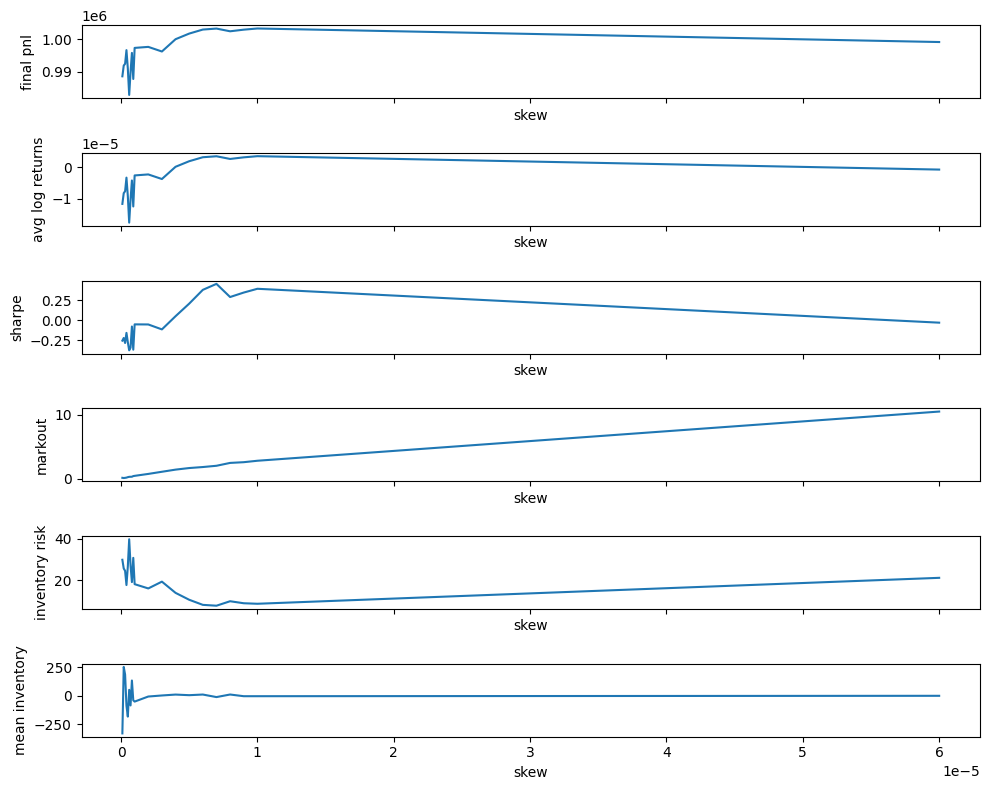

In [7]:
import pandas as pd
rng = np.random.default_rng(seed=1)
skew_coefficients = np.concat([np.arange(1e-7, 1e-6, 1e-7), np.arange(1e-6, 1e-5,1e-6), np.arange(1e-5, 1e-4, 5e-5)])
results = []
for sc in skew_coefficients:
    avg_metrics = simulate(0.3, sc, n=5, rng=rng, timesteps=1000, price_vol=0.05)
    avg_metrics["skew"] = sc
    results.append(avg_metrics)

df = pd.DataFrame(results)
metrics_to_plot = ["final pnl", "avg log returns", "sharpe", "markout", "inventory risk", "mean inventory"]

fig, ax = plt.subplots(nrows=len(metrics_to_plot), figsize=(10,8), sharex=True)

for ax, metric in zip(ax, metrics_to_plot):
    ax.plot(df['skew'], df[metric])
    ax.set_ylabel(metric)
    ax.set_xlabel('skew')

fig.tight_layout()
fig.show()

    


In [31]:
from tqdm.notebook import tqdm
import numpy as np
#from multiprocessing import Pool 
from joblib import Parallel, delayed
rng = np.random.default_rng(seed=1)
skew_coefficients = np.concat([np.arange(1e-6,1e-5,1e-6), np.arange(1e-5, 1e-4, 1e-5)])

def process_one_regime(args):
    frac, vol, skew = args
    max_sharpe, max_pnl = crude_optimiser(frac, vol, skew)
    return frac, vol, max_sharpe, max_pnl
    
def crude_optimiser(informed_frac, price_vol, skew_search_space):
    max_sharpe = [0, -float('inf')]
    max_pnl = [0, -float('inf')]
    for sc in skew_search_space:
        avg_metrics = simulate(informed_frac=informed_frac, price_vol=price_vol, skew_coefficient=sc, n=3, rng=rng, timesteps=500)

        if avg_metrics["sharpe"] > max_sharpe[1]:
            max_sharpe = [sc, avg_metrics["sharpe"]]
        if avg_metrics["final pnl"] > max_pnl[1]:
            max_pnl = [sc, avg_metrics["final pnl"]]

    return max_sharpe, max_pnl

def optimal_sharpe_regime(informed_frac_space, price_vol_space, skew_search_space):
    tasks = [(frac, vol, skew_search_space)
             for frac in informed_frac_space
             for vol in price_vol_space]

    # for notebook
    results = Parallel(n_jobs=-1, verbose=5)(
        delayed(process_one_regime)(task) 
        for task in tasks
    )
    
    # with Pool() as pool:
    #     results = list(tqdm(
    #         pool.imap(process_one_regime, tasks),
    #         total=len(tasks)
    #     ))
    
    m, n = len(informed_frac_space), len(price_vol_space)
    optimal_sc_pnl = np.zeros([m, n])
    optimal_pnl = np.zeros([m, n])
    optimal_sc_sharpe = np.zeros([m, n])
    optimal_sharpe = np.zeros([m, n])
    
    for frac, vol, max_sharpe, max_pnl in results:
        i = list(informed_frac_space).index(frac)
        j = list(price_vol_space).index(vol)
        optimal_sc_pnl[i, j] = max_pnl[0]
        optimal_pnl[i, j] = max_pnl[1]
        optimal_sc_sharpe[i, j] = max_sharpe[0]
        optimal_sharpe[i, j] = max_sharpe[1]

    return {
        "optimal sc-pnl": optimal_sc_pnl,
        "optimal pnl": optimal_pnl,
        "optimal sc-sharpe": optimal_sc_sharpe,
        "optimal sharpe": optimal_sharpe
    }
        
informed_frac_space = np.arange(0.1, 1, 0.02)
price_vol_space = np.arange(0.01,0.1,0.005)
res = optimal_sharpe_regime(informed_frac_space, price_vol_space, skew_coefficients)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:   57.5s
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 628 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:  5.1min finished


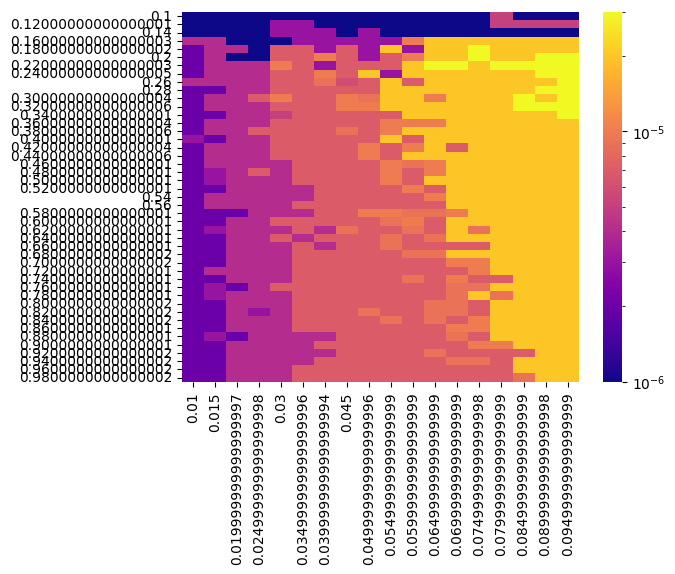

In [37]:
import seaborn as sns
from matplotlib.colors import LogNorm
optimal_sc_pnl = res["optimal sc-pnl"]
optimal_sc_sharpe = res["optimal sc-sharpe"]
optimal_sharpe = res["optimal sharpe"]
ax = sns.heatmap(optimal_sc_sharpe, yticklabels=list(informed_frac_space), xticklabels=list(price_vol_space), norm=LogNorm(), cmap='plasma', robust=True)
#ax = sns.heatmap(optimal_sharpe)

[[ 3.03576178e+00  2.75502784e+00  2.21408325e+00  1.66595694e+00
   1.56149908e+00  1.35410995e+00  1.25061856e+00  1.15610873e+00
   9.72798963e-01  7.53138353e-01  7.43033078e-01  6.16986342e-01
   5.05770221e-01  4.15480069e-01  3.53115909e-01  4.54005941e-01
   4.11835132e-01  3.34383128e-01]
 [ 3.07756177e+00  2.88976902e+00  2.15775459e+00  1.59405445e+00
   1.33243884e+00  1.10175177e+00  8.53670902e-01  7.14851221e-01
   7.42037246e-01  6.65448507e-01  5.76300077e-01  5.09430881e-01
   4.64155631e-01  3.88112364e-01  3.31976504e-01  2.81366196e-01
   3.13051765e-01  1.82306220e-01]
 [ 2.99511166e+00  2.38660670e+00  2.02093695e+00  1.49931825e+00
   1.32088117e+00  1.09623520e+00  8.29194521e-01  6.59868535e-01
   8.42283002e-01  4.71101963e-01  5.22248501e-01  4.22376506e-01
   3.86410530e-01  2.99925399e-01  2.75037892e-01  2.18630203e-01
   1.86635886e-01  1.15174965e-01]
 [ 2.90867977e+00  2.34148007e+00  1.65159648e+00  1.28016787e+00
   1.20866532e+00  9.37002734e-01  9.

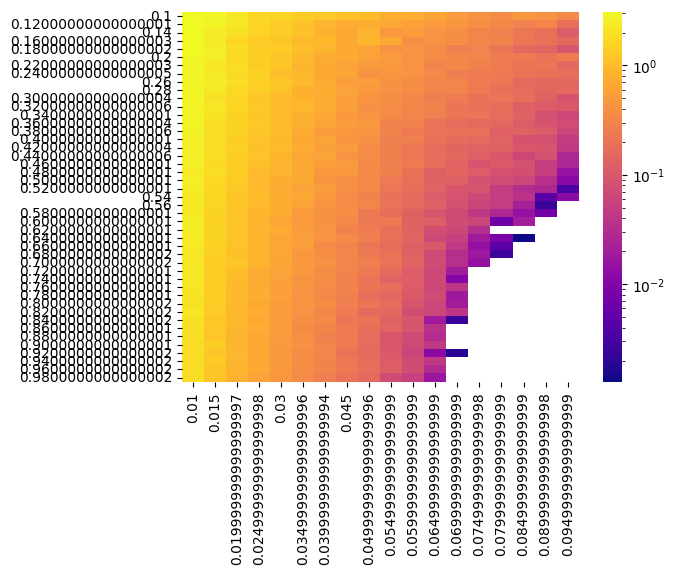

In [ ]:
ax = sns.heatmap(res["optimal sharpe"], yticklabels=list(informed_frac_space), xticklabels=list(price_vol_space), norm=LogNorm(), cmap='plasma', robust=False)